# Importar librerías

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, mean_squared_error, recall_score

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, mean_squared_error, recall_score

import random
from sklearn.model_selection import GridSearchCV
from scipy import stats

from datetime import datetime
from google.colab import files

import random
import pickle

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Funciones

In [ ]:
def dat_activo(dat):
  cond_int = dat.att.reset_index()
  cond_int.columns = ['index',0]
  cond_int['index'] = range(1,len(cond_int)+1)
  cond_act = cond_int['index']>=min(cond_int[cond_int[0]==0]['index'])
  cond_act.index = dat.index
  dat_periodo_activo = dat[cond_act]
  dat_periodo_inactivo = dat[~cond_act]
  return dat_periodo_activo, dat_periodo_inactivo

def fix_code(x,l=5):
    x = str(x)
    x = x.replace('.0','')
    while len(x) < l:
        x = '0'+x
    return x

def p90(x):
  return np.percentile(x,q=[90])[0]

def p75(x):
  return np.percentile(x,q=[75])[0]

def p25(x):
  return np.percentile(x,q=[25])[0]

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# Obtener los periodos de inactividad y su duración
def periodos_inact_1(condicion):
  cond_int = condicion.astype(int).reset_index()
  cond_int.columns = ['index',0]
  cond_int['index'] = range(1,len(cond_int)+1)
  if cond_int[0][len(cond_int)-1] == 1:
    cond_int = pd.concat([cond_int,pd.DataFrame({'index':[len(cond_int)+1],0:[0]})])
  cond_int['cs'] = np.cumsum(cond_int[0])
  cond_int['t_1'] = cond_int[0].shift(1)
  cond_int = cond_int.fillna(0)

  cond_int['diff'] = cond_int['t_1']-cond_int[0]

  cond_ = cond_int[cond_int['diff']>0]
  cond_['saltos'] = cond_['cs']-cond_['cs'].shift(1).fillna(0)
  cond_ = cond_[['index','saltos']]
  cond_.columns = ['periodo','saltos']
  return cond_



def periodos_inact(condicion):
  cond_int = condicion.astype(int).reset_index()
  cond_int.columns = ['index',0]
  cond_int['index'] = range(1,len(cond_int)+1)

  # Quitar las partes iniciales sin actividad
  cond_int = cond_int[cond_int['index']>=min(cond_int[cond_int[0]==0]['index'])]
  cond_int['index_2'] = range(1,len(cond_int)+1)

  ul_per_inac = cond_int[0].iloc[len(cond_int)-1] == 1
  
  if ul_per_inac:
    cond_int = pd.concat([cond_int,pd.DataFrame({'index':[len(cond_int)+1],0:[0]})])
  cond_int['cs'] = np.cumsum(cond_int[0])
  cond_int['t_1'] = cond_int[0].shift(1)
  cond_int = cond_int.fillna(0)

  cond_int['diff'] = cond_int['t_1']-cond_int[0]

  cond_ = cond_int[cond_int['diff']>0]
  cond_['saltos'] = cond_['cs']-cond_['cs'].shift(1).fillna(0)
  cond_['abandono_vigente'] = 0

  if ul_per_inac & len(cond_)==1:
    cond_['abandono_vigente'] = 1
  cond_ = cond_[['index','index_2','saltos','abandono_vigente']]
  cond_.columns = ['periodo','periodo_orig','saltos','abandono_vigente']

  return cond_

# Lectura de Datos

In [ ]:
url = 'https://drive.google.com/file/d/1FVaApPUR3dn_WP66k8KHcWUunRH-RG-E/view?usp=sharing'

id_ = url.split('/')[-2]

links = drive.CreateFile({'id':id_})
links.GetContentFile('doc.csv')

tup = tabla_uso_productos = pd.read_csv('doc.csv', delimiter=',', encoding= 'unicode_escape')

!rm doc.csv

# Primera definición de attrition: cuando un cliente tiene 0 transacciones y 0 montos transaccionales

In [ ]:
#Cambiar tipos
tup['CLIENTE'] = tup['CLIENTE'].apply(lambda x: fix_code(x,8))
tup['FECHA'] = pd.to_datetime(tup['FECHA'])
tup['OPE'] = tup['OPE'].astype(int)

tup['anio'] = tup.FECHA.dt.year
tup['mes'] = tup.FECHA.dt.month

tup['CLIENTE'] = tup['CLIENTE'].apply(lambda x: fix_code(x,8))

In [ ]:
tup.head(1)

,CLIENTE,FECHA,ING,OPE,USO,FON_ING,FON_ING_IND,FON_OPE,FON_OPE_IND,FON_USO,FON_USO_IND,PMN_ING,PMN_ING_IND,PMN_OPE,PMN_OPE_IND,PMN_USO,PMN_USO_IND,VME_ING,VME_ING_IND,VME_OPE,VME_OPE_IND,VME_USO,VME_USO_IND,VMN_ING,VMN_ING_IND,VMN_OPE,VMN_OPE_IND,VMN_USO,VMN_USO_IND,VIG_ING,VIG_ING_IND,VIG_OPE,VIG_OPE_IND,VIG_USO,VIG_USO_IND,att,mes,ANTIGUEDAD,USO_Tmenos1,OPE_Tmenos1,...,SEGMENTO_G,valor_vinculacion,sector_asset_OTROS,sector_asset_Capital goods & Industrial services,sector_asset_Retail,sector_asset_Real Estate,sector_asset_Consumer,sector_asset_Leisure & Consumer Services,sector_asset_Construction & Construction Materials,"sector_asset_Autos, components & Durable goods",sector_asset_Energy (Oil & Gas),sector_asset_Transportation,sector_asset_Basic Materials,"sector_asset_Telecoms, Technology & Media",SEGMENTO_G_OTROS,SEGMENTO_G_EMPRESARIAL,SEGMENTO_G_EMP. MEDIANA,SEGMENTO_G_CORPORATIVO E,SEGMENTO_G_E TIER 1,CD_ESTADO_OTROS,CD_ESTADO_DF,CD_ESTADO_JA,CD_ESTADO_EM,CD_ESTADO_NL,CD_ESTADO_PU,CD_ESTADO_QR,CD_ESTADO_VE,CD_ESTADO_SO,CD_ESTADO_GU,CD_ESTADO_QU,CD_ESTADO_CH,CD_ESTADO_SI,CD_ESTADO_MI,CD_ESTADO_BN,CD_ESTADO_CU,CD_ESTADO_YU,CD_ESTADO_SL,CD_ESTADO_TM,CD_ESTADO_BS,anio
0,00171484,2018-07-31,15707.45,418,18662650.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.101041e+06,6.0,0.0,0.0,0.0,0.0,10965570.72,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,22.22,0.0,0.0,...,EMPRESARIAL,3.4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018


In [ ]:
tup

,CLIENTE,FECHA,ING,OPE,USO,FON_ING,FON_ING_IND,FON_OPE,FON_OPE_IND,FON_USO,FON_USO_IND,PMN_ING,PMN_ING_IND,PMN_OPE,PMN_OPE_IND,PMN_USO,PMN_USO_IND,VME_ING,VME_ING_IND,VME_OPE,VME_OPE_IND,VME_USO,VME_USO_IND,VMN_ING,VMN_ING_IND,VMN_OPE,VMN_OPE_IND,VMN_USO,VMN_USO_IND,VIG_ING,VIG_ING_IND,VIG_OPE,VIG_OPE_IND,VIG_USO,VIG_USO_IND,att,mes,ANTIGUEDAD,USO_Tmenos1,OPE_Tmenos1,...,SEGMENTO_G,valor_vinculacion,sector_asset_OTROS,sector_asset_Capital goods & Industrial services,sector_asset_Retail,sector_asset_Real Estate,sector_asset_Consumer,sector_asset_Leisure & Consumer Services,sector_asset_Construction & Construction Materials,"sector_asset_Autos, components & Durable goods",sector_asset_Energy (Oil & Gas),sector_asset_Transportation,sector_asset_Basic Materials,"sector_asset_Telecoms, Technology & Media",SEGMENTO_G_OTROS,SEGMENTO_G_EMPRESARIAL,SEGMENTO_G_EMP. MEDIANA,SEGMENTO_G_CORPORATIVO E,SEGMENTO_G_E TIER 1,CD_ESTADO_OTROS,CD_ESTADO_DF,CD_ESTADO_JA,CD_ESTADO_EM,CD_ESTADO_NL,CD_ESTADO_PU,CD_ESTADO_QR,CD_ESTADO_VE,CD_ESTADO_SO,CD_ESTADO_GU,CD_ESTADO_QU,CD_ESTADO_CH,CD_ESTADO_SI,CD_ESTADO_MI,CD_ESTADO_BN,CD_ESTADO_CU,CD_ESTADO_YU,CD_ESTADO_SL,CD_ESTADO_TM,CD_ESTADO_BS,anio
0,00171484,2018-07-31,15707.45,418,18662650.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.101041e+06,6.0,0.0,0.0,0.0,0.0,10965570.72,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7,22.22,0.00,0.0,...,EMPRESARIAL,3.400000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
1,00171484,2018-08-31,19431.18,445,68496549.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.611229e+06,6.0,0.0,0.0,0.0,0.0,10568257.38,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8,22.31,18662650.95,418.0,...,EMPRESARIAL,3.400000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
2,00171484,2018-09-30,16938.99,386,89411054.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.735936e+06,6.0,0.0,0.0,0.0,0.0,22868805.72,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9,22.39,68496549.02,445.0,...,EMPRESARIAL,3.400000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
3,00171484,2018-10-31,31132.02,633,36324016.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.775059e+06,6.0,0.0,0.0,0.0,0.0,13061162.10,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,10,22.47,89411054.69,386.0,...,EMPRESARIAL,3.400000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
4,00171484,2018-11-30,28948.54,724,34964214.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.135974e+06,6.0,0.0,0.0,0.0,0.0,11344083.48,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0,11,22.55,36324016.45,633.0,...,EMPRESARIAL,3.400000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352335,C8204646,2021-02-28,0.00,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,0.00,0.00,0.0,...,EMPRESARIAL,1.666667,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021
1352336,C8204646,2021-03-31,0.00,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3,0.00,0.00,0.0,...,EMPRESARIAL,1.666667,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021
1352337,C8204646,2021-04-30,0.00,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,0.00,0.00,0.0,...,EMPRESARIAL,1.666667,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021
1352338,C8204646,2021-05-31,0.00,0

# Obtención size/count churn dependiendo del segmento
Veremos los "saltos" que hay entre meses de inactividad Evaluar atrition dado el producto a partir de los saltos del percentil 90% -> Ej. Inv 5 periodos, Vista 3 periodos -> Attrition

In [ ]:
regist = pd.pivot_table(tup,index=['CLIENTE'],values='FECHA',aggfunc=len)
# regist.FECHA.value_counts()[:10]
No_36 = regist[regist.FECHA!=36]
print(len(No_36))

0


In [ ]:
tup_date_36 = tup
tup_date_36.sort_values(['CLIENTE'],inplace=True)
valores = tup_date_36[['CLIENTE']].drop_duplicates().values
len(valores)

37565

In [ ]:
# 6 Min para ejecutar
pd_info2 = pd.DataFrame()

for i, (cl) in enumerate(valores):
  
  indice = i*36
  indice2 = indice+36
  dat = tup_date_36.iloc[indice:indice2,:]

  condicion = (dat['att']==1)
  # Si siempre hay actividad o nunca la hay me salto el caso
  # porque no hay saltos
  if (sum(condicion)==0 or sum(condicion)==36):
    continue

  data_saltos = periodos_inact(condicion)
  data_saltos['p_no_actividad'] = sum(condicion)/len(dat)
  data_saltos['cliente'] = cl[0]
  # data_saltos['producto'] = pr

  pd_info2 = pd.concat([pd_info2,data_saltos],axis=0)
  if i%1000==0:
    print(i)
    
  # if i==6000:
  #   break
  #   print(i)

pd_info2.to_csv('info_cliente.csv')

# condicion = pd.Series([True if random.random()>1 else False for i in range(15)])

1000
2000
6000


In [ ]:
# (checkpoint)
# url='https://drive.google.com/file/d/1iIbMAUzqgUbHos8zCmXI1m5fBQkip68-/view?usp=sharing'
# id_ = url.split('/')[-2]

# links = drive.CreateFile({'id':id_})
# links.GetContentFile('doc.csv')

# pd_info2 = pd.read_csv('doc.csv', delimiter=',', encoding= 'unicode_escape')

In [ ]:
pd_info2

,periodo,periodo_orig,saltos,abandono_vigente,p_no_actividad,cliente
28,29,29.0,8.0,0,0.222222,00215740
19,20,20.0,2.0,0,0.472222,00431648
35,36,36.0,15.0,0,0.472222,00431648
18,19,19.0,1.0,0,0.027778,00438855
18,19,19.0,1.0,0,0.027778,00512516
...,...,...,...,...,...,...
17,18,17.0,1.0,0,0.388889,21762513
27,28,27.0,1.0,0,0.388889,21762513
32,33,32.0,4.0,0,0.388889,21762513
0,36,0.0,1.0,0,0.388889,21762513


In [ ]:
pd_info2_ = pd_info2.copy()
#Tamaño de los periodos antes de abandonar
# Entonces eliminar los periodos 37 y los abandonos vigentes
saltos_varios = pd_info2[(pd_info2['abandono_vigente']==0)&(pd_info2['periodo']<37)]

In [ ]:
# Los casos de abandono de un mes a otro se vuelve 0 son los de abandono_vigente
# Para ellos su salto fue de tamaño 1, entonces aquellos que tengan sus últimos periodos de
# inactividad se contarán como que ya no van a regresar... no son casos con 0 saltos
pd_info2_.loc[(pd_info2_['abandono_vigente']==1)|(pd_info2_['periodo']==37),['saltos']]=0

In [ ]:
segment = tup[['CLIENTE','SEGMENTO_G']].drop_duplicates()
pd_info2_ = pd_info2_.merge(segment,left_on='cliente',right_on='CLIENTE',how='left').drop(columns=['cliente'])

In [ ]:
pd_info2_['count_saltos'] = [1 if x>0 else 0 for x in pd_info2_.saltos]

saltos_count = pd.pivot_table(pd_info2_,index=['SEGMENTO_G','CLIENTE'],values='count_saltos',aggfunc='sum').reset_index()
saltos_size = pd.pivot_table(pd_info2_,index=['SEGMENTO_G','CLIENTE'],values='saltos',aggfunc='mean').reset_index()

saltos_size_prod = pd.pivot_table(saltos_size,index='SEGMENTO_G',values='saltos',aggfunc=['mean','std','min',p25,'median',p75,p90,'max'])
saltos_count_prod = pd.pivot_table(saltos_count,index='SEGMENTO_G',values='count_saltos',aggfunc=['mean','std','min',p25,'median',p75,p90,'max'])
att_rule_1 = saltos_size_prod['p90']['saltos'].reset_index()
att_rule_2 = saltos_count_prod['p90']['count_saltos'].reset_index()

In [ ]:
saltos_count_prod.to_csv('Count_cliente.csv',index=False)
files.download('Count_cliente.csv')
saltos_size_prod.to_csv('Size_cliente.csv',index=False)
files.download('Size_cliente.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Creación de la Variable objetivo y Tabla Pivote

In [ ]:
segment = segment.merge(att_rule_1,on='SEGMENTO_G').merge(att_rule_2,on='SEGMENTO_G')
# tup = tup.merge(segment,on='CLIENTE',how='left')

In [ ]:
valores = segment[['CLIENTE','SEGMENTO_G','saltos','count_saltos']].drop_duplicates().values
len(valores)

37559

In [ ]:
tup_date = tup.copy()
asfa = tup_date.CLIENTE.value_counts()
asfa[asfa!=36]

Series([], Name: CLIENTE, dtype: int64)

In [ ]:
# Timepo: 1 hrs
# Aplicar la regla 1: Después de un salto mayor al del percentil del 90% se considera att
# Aplicar la regla 2: Después del n-ésimo salto mayor al del percentil del 90% se considera att

valores = segment[['CLIENTE','SEGMENTO_G','saltos','count_saltos']].drop_duplicates().values
pd_update_att = pd.DataFrame()
pd_update_inact = pd.DataFrame()

for i, (cl,pr,salto_size,num_saltos) in enumerate(valores):
  salto_size = int(salto_size)
  num_saltos = int(num_saltos)
  
  indice = i*36
  indice2 = indice+36
  dat = tup_date.iloc[indice:indice2,:]
  condicion = dat['att']==1

  if (sum(condicion)==0):
    # pd_update_inact = pd.concat([pd_update_inact,dat],axis=0)
    continue

  if (sum(condicion)==36):
    continue

  activo, inactivo = dat_activo(dat)
  
  # todos los periodos de inactividad inicial los retiramos
  if len(inactivo)>0:
    1

  data_saltos = periodos_inact(condicion)
  if len(data_saltos)==0:
    continue

  # if len(data_saltos)>1:
  #   break
  # Aplica regla 1
  Regla1 = any(data_saltos.saltos>salto_size)
  # Aplica regla 2
  Regla2 = len(data_saltos)>num_saltos

  activo['var_obj_size'] = 0
  activo['var_obj_count'] = 0

  if Regla1:
    #Poner 1's a las fechas después del salto más alto permitido
    var_obj = list(np.zeros(salto_size+1))

    for row in range(salto_size+1,len(activo)):
      reg_anteriores = activo.iloc[(row-salto_size-1):row,:]
      reg_actual = activo.iloc[row,:]
      # si los registros anteriores y el actual son 0 -> attrition
      if all(reg_anteriores.att==1) and reg_actual.att==1:
        var_obj += [1]
      else:
        var_obj += [0]

    activo['var_obj_size'] = var_obj

  if Regla2:
    #Poner 1's a las fechas que superen el mayor número de saltos
    saltos_de_att = data_saltos.iloc[num_saltos:,:]
    primer_periodo_att = min(saltos_de_att.periodo_orig-saltos_de_att.saltos)-1

    var_obj = list(np.zeros(len(activo.iloc[:int(primer_periodo_att),:].att)))
    var_obj += activo.iloc[int(primer_periodo_att):,:].att.tolist()
    activo['var_obj_count'] = var_obj
  
  pd_update_att = pd.concat([pd_update_att,activo],axis=0)
  
  if i%5000==0:
    print(i)
    pd_update_att.to_csv('update_att_cl.csv',header=True,index=False)
    # pd_update_inact.to_csv('update_inact.csv',header=True,index=False)

pd_update_att.to_csv('update_att_cl.csv',header=True,index=False)
# pd_update_inact.to_csv('update_inact.csv',header=True,index=False)
print('T maño: ',pd_update_att.shape[0])

In [ ]:
# from google.colab import files
# files.download('update_att_cl.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Nuevas variables

In [ ]:
url = 'https://drive.google.com/file/d/1yoLiQ57Pt3A-EsxIYiUKIVyrRBW8oL99/view?usp=sharing'
id_ = url.split('/')[-2]
links = drive.CreateFile({'id':id_})
links.GetContentFile('doc.csv')

pd_update_att = pd.read_csv('doc.csv', delimiter=',', encoding= 'unicode_escape')

In [ ]:
pd_update_att['VAR_OBJ'] = pd_update_att.var_obj_size+pd_update_att.var_obj_count
pd_update_att_ = pd_update_att.copy()
pd_update_att_.drop(columns = ['var_obj_size','var_obj_count'],inplace=True)

In [ ]:
try:
  pd_update_att_.drop(columns=['SEGMENTO_G_x','SEGMENTO_G_y'], inplace=True)
except:
  1
try:
  pd_update_att_.drop(columns=['SEGMENTO_G'], inplace=True)
except:
  1

# Random Forest

In [ ]:
semilla = 1234

In [ ]:
va_obj = 'VAR_OBJ'

In [ ]:
uso_prod1 = pd_update_att_.copy()
pivote= uso_prod1.dropna(subset = [va_obj])
ids_ = [va_obj,'CLIENTE','FECHA','anio','id_client_fecha']
X = pivote.drop(columns=ids_).fillna(0)
y = pivote[va_obj].apply(lambda x: min(x,1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=semilla)

In [ ]:
random.seed(semilla)
# GridSearch
rf = RandomForestRegressor(random_state=semilla)
param_grid = {'n_estimators':[180],'max_depth':[8]}
cv = GridSearchCV(rf,param_grid=param_grid,cv=5,n_jobs=-1, verbose=2)
cv.fit(X_train,y_train)

### Variables importantes

In [ ]:
#Variables importantes
importances = list(cv.best_estimator_.feature_importances_)
feature_list=list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
var_impr_gral=[pair[0] for pair in feature_importances if pair[1]>0]
var_import=pd.DataFrame(feature_importances, columns=['Variable','Importancia'])
var_import_may_0=var_import[var_import['Importancia'] > 0]
var_import_may_0

,Variable,Importancia
0,att,0.64
1,delta_OPE_1vs2trimestre,0.16
2,VINC,0.10
3,OPE,0.02
4,OPE_Tmenos2,0.02
5,saltos,0.01
6,ANTIGUEDAD,0.01
7,delta_ING_1vs2meses,0.01


In [ ]:
var_imp_R = ['att', 'delta_OPE_1vs2trimestre', 'VINC', 'OPE', 'OPE_Tmenos2','saltos', 'ANTIGUEDAD', 'delta_ING_1vs2meses']

# Mejores Variables

## WOE-Information Value

Hacemos 20 grupos para crear el WOE y IV, para esto creamos las funciones <b>mono_bin</b> para calcular el poder predictivo de las variables del modelo, <b>char_bin</b> se verifica que cada contenedor debe ser distinto de cero para eventos y no eventos y  <b>data_vars</b> selecionamos las variables importantes de el modelo de RandomForest y clasificamos las variables en función de su importancia, utilizando los resultados del WOE.

In [ ]:
from pandas import Series
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import traceback
import re

In [ ]:
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

Llamamos a nuestra funcion <b>data_vars</b> para calcular el valor de la informaciòn de cada una de nuestras variables de <b>pivote_CPS</b>.

In [ ]:
IVs = pd.DataFrame(data = list(range(2))).transpose()
IVs.columns = ['VAR_NAME', 'IV']
IVs = IVs.iloc[:-1,]
Flags = [va_obj]
for flag in Flags:
  final_iv, IV = data_vars(X, uso_prod1[flag])
  IVs = pd.concat([IVs, IV])

IVs.sort_values(by='IV', ascending=False).head()

,VAR_NAME,IV
45,USO_Tmenos1,3.511969
31,OPE_Tmenos1,3.343813
46,USO_Tmenos2,3.219160
32,OPE_Tmenos2,2.941342
73,delta_USO_1vs2trimestre,2.918640


Hacemos un DataFrame <b>list_ivs_1</b> solo con las variables cuyo poder predictivo sea medio .

In [ ]:
ivs = IVs.sort_values(by='IV', ascending=False)
lis_ivs_1 = ivs[ivs.IV>.15]['VAR_NAME'].tolist()

# Modelo con mejores variables

Hacemos una lista <b>var_imp_R_</b> con todas las variables importantes que son las variable del information value <b>lis_ivs_1</b>, <b>var_impr_gral</b> variables con mayor importancia del entrenamiento del Random Forest y <b>vars_impr_corr</b> las variables del resultado de la correlación de la variable objetivo.

In [ ]:
var_imp_R = var_imp_R_ = pd.Series(lis_ivs_1).unique()
len(var_imp_R)

In [ ]:
pivote= uso_prod1#.dropna(subset = [va_obj])
ids_ = [va_obj,'GRUPO','SEGMENTO_G','FECHA','id_client_fecha','anio']
# X = pivote.drop(columns=ids_).fillna(0)

X = pivote[var_imp_R].fillna(0)
y = pivote[va_obj].apply(lambda x: min(x,1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=112)

In [ ]:
#GridSearch
rf = RandomForestRegressor(random_state=np.random.RandomState(seed=semilla))
param_grid = {'n_estimators':range(50,550,120),'max_depth':range(3,11,3)}
# param_grid = {'n_estimators':[450],'max_depth':[11]}
cv = GridSearchCV(rf,param_grid=param_grid,cv=5,n_jobs=-1)
cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False,
                                             random_state=RandomState(MT19937) at 0x7F17659B7160,
                               

Calculamos el error del modelo ahora con las nuevas variables.

In [ ]:
y_pred = cv.best_estimator_.predict(X_train)
pd.Series(y_pred).value_counts()

# Evaluación

In [ ]:
y_pred = cv.best_estimator_.predict(X_test)

r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

0.7640016668317035

In [ ]:
predicciones = y_pred = cv.best_estimator_.predict(X)
predicciones = [0 if x<.7 else 1 for x in predicciones]
rmse = mean_squared_error(y_true  = y, y_pred  = predicciones, squared = False) 
print(f"El error (rmse) de traint es: {rmse}")

predicciones = cv.predict(X = X_test)#Error de test
# predicciones = y_pred = cv.best_estimator_.predict(X_)
predicciones = [0 if x<.7 else 1 for x in predicciones]
rmse = mean_squared_error(y_true  = y_test,y_pred  = predicciones,squared = False)
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de traint es: 0.23658490946708363
El error (rmse) de test es: 0.240041992540731


In [ ]:
roc_auc_score(y_test, predicciones)

0.8562419201548578

In [ ]:
filename = 'model_beyg_clientes_2.0.sav'
pickle.dump(cv, open(filename, 'wb'))
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

In [ ]:
# var_imp_R = ['delta_OPE_1vs2trimestre', 'att','OPE', 'saltos','ANTIGUEDAD', 'OPE_Tmenos2', 'delta_OPE_1vs2meses']

filename = 'model_beyg_clientes.sav'
cv = pickle.load(open(filename, 'rb'))
result = cv.score(X_test[var_imp_R], y_test)

In [ ]:
y_pred = cv.best_estimator_.predict(X_test)

r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

0.7609138632879057

## Evaluación metricas

In [ ]:
y_test_pred= predicciones

Matriz de Confusion


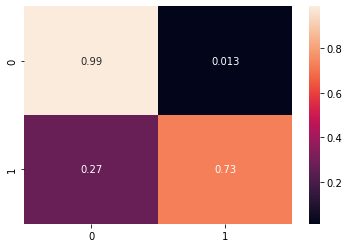


precision: 0.9214561188975637
exhaustividad: 0.7252535722218109
ROC AUC: 0.8562419201548578
accuracy in test: 0.9423798418170757


In [ ]:
# Imprimir metricas
print('Matriz de Confusion')
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
sns.heatmap(confusion_matrix(y_test, y_test_pred, normalize='true'), annot=True);
plt.show()
print('')

print('precision:', tp/(tp+fp))
print('exhaustividad:', tp/(tp+fn))
print('ROC AUC:', roc_auc_score(y_test, y_test_pred))
# print('accuracy in train:', accuracy_score(y_train_pred, y_train))
print('accuracy in test:', accuracy_score(y_test_pred, y_test))

In [ ]:
mean_squared_error( y_test, y_test_pred, squared=False)

0.240041992540731

In [ ]:
recall_score( y_test, y_test_pred)

0.7252535722218109

In [ ]:
f1_score( y_test, y_test_pred)

0.8116662523821361